### **Ник на Kaggle: Артём_Закарейшвили_158812417**

# Домашнее задание. Классификация изображений

Сегодня вам предстоить помочь телекомпании FOX в обработке их контента. Как вы знаете, сериал "Симпсоны" идет на телеэкранах более 25 лет, и за это время скопилось очень много видеоматериала. Персоонажи менялись вместе с изменяющимися графическими технологиями, и Гомер Симпсон-2018 не очень похож на Гомера Симпсона-1989. В этом задании вам необходимо классифицировать персонажей, проживающих в Спрингфилде. Думаю, нет смысла представлять каждого из них в отдельности.



## Приключение?

А теперь самое интересное, мы сделали простенькую сверточную сеть и смогли отправить сабмит, но получившийся скор нас явно не устраивает. Надо с этим что-то сделать.

Несколько срочныйх улучшейни для нашей сети, которые наверняка пришли Вам в голову:


*   Учим дольше и изменяем гиперпараметры сети
*  learning rate, batch size, нормализация картинки и вот это всё
*   Кто же так строит нейронные сети? А где пулинги и батч нормы? Надо добавлять
*  Ну разве Адам наше все? [adamW](https://www.fast.ai/2018/07/02/adam-weight-decay/) для практика, [статейка для любителей](https://openreview.net/pdf?id=ryQu7f-RZ) (очень хороший анализ), [наши ](https://github.com/MichaelKonobeev/adashift/) эксперименты для заинтересованных.

* Ну разве это deep learning? Вот ResNet и Inception, которые можно зафайнтьюнить под наши данные, вот это я понимаю (можно и обучить в колабе, а можно и [готовые](https://github.com/Cadene/pretrained-models.pytorch) скачать).

* Данных не очень много, можно их аугументировать и  доучититься на новом датасете ( который уже будет состоять из, как  пример аугументации, перевернутых изображений)

* Стоит подумать об ансамблях


Надеюсь, что у Вас получится!

![alt text](https://pbs.twimg.com/profile_images/798904974986113024/adcQiVdV.jpg)


In [2]:
import torch
import numpy as np

train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is available!  Training on GPU ...


In [3]:
!gdown 1mgKW-CwwWvC3R3hSGGCPCSZIJwp35SsO

Downloading...
From (original): https://drive.google.com/uc?id=1mgKW-CwwWvC3R3hSGGCPCSZIJwp35SsO
From (redirected): https://drive.google.com/uc?id=1mgKW-CwwWvC3R3hSGGCPCSZIJwp35SsO&confirm=t&uuid=efca1c07-4451-41ed-a1e7-99202ee3ab7d
To: /content/journey-springfield.zip
100% 546M/546M [00:08<00:00, 60.7MB/s]


In [4]:
!unzip -q journey-springfield.zip

In [5]:
#Установка зависимостей
import pickle
import numpy as np
from skimage import io

from tqdm import tqdm, tqdm_notebook
from PIL import Image
from pathlib import Path

from torchvision import transforms
from multiprocessing.pool import ThreadPool
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
from sklearn.metrics import f1_score

from matplotlib import colors, pyplot as plt
%matplotlib inline

# в sklearn не все гладко, чтобы в colab удобно выводить картинки
# мы будем игнорировать warnings
import warnings
warnings.filterwarnings(action='ignore', category=DeprecationWarning)

In [6]:
# разные режимы датасета
DATA_MODES = ['train', 'val', 'test']
# все изображения будут масштабированы к размеру 224x224 px
RESCALE_SIZE = 224
# работаем на видеокарте
DEVICE = torch.device("cuda")

In [7]:
#Изменённый класс SimpsonsDataset (добавили transform, чтобы делать аугментации)
class SimpsonsDataset(Dataset):
    def __init__(self, files, mode, transform=None):
        super().__init__()
        self.files = sorted(files)
        self.mode = mode
        self.transform = transform  # добавляем параметр transform

        if self.mode not in DATA_MODES:
            print(f"{self.mode} is not correct; correct modes: {DATA_MODES}")
            raise NameError

        self.len_ = len(self.files)

        self.label_encoder = LabelEncoder()

        if self.mode != 'test':
            self.labels = [path.parent.name for path in self.files]
            self.label_encoder.fit(self.labels)

            with open('label_encoder.pkl', 'wb') as le_dump_file:
                pickle.dump(self.label_encoder, le_dump_file)

    def __len__(self):
        return self.len_

    def load_sample(self, file):
        image = Image.open(file)
        image.load()
        return image

    def __getitem__(self, index):
        x = self.load_sample(self.files[index])
        x = self._prepare_sample(x)

        # Применяем аугментацию, если она задана
        if self.transform:
            x = self.transform(x)

        if self.mode == 'test':
            return x
        else:
            label = self.labels[index]
            label_id = self.label_encoder.transform([label])
            y = label_id.item()
            return x, y

    def _prepare_sample(self, image):
        image = image.resize((RESCALE_SIZE, RESCALE_SIZE))
        return image

In [8]:
#определим директории с тренировочными и тестовыми файлами
TRAIN_DIR = Path('./train/')
TEST_DIR = Path('./testset')

train_val_files = sorted(list(TRAIN_DIR.rglob('*.jpg')))
test_files = sorted(list(TEST_DIR.rglob('*.jpg')))

from sklearn.model_selection import train_test_split

train_val_labels = [path.parent.name for path in train_val_files]
train_files, val_files = train_test_split(train_val_files, test_size=0.25, \
                                          stratify=train_val_labels)

In [9]:
#Аугментация и станадртная обработка для тренрировных данных
train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.Resize((RESCALE_SIZE, RESCALE_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

#Стандартная обработка для данных для валидации
val_transform = transforms.Compose([
    transforms.Resize((RESCALE_SIZE, RESCALE_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

train_dataset = SimpsonsDataset(train_files, mode='train', transform=train_transform)
val_dataset = SimpsonsDataset(val_files, mode='val', transform=val_transform)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)

In [10]:
from torchvision.models import resnet50, ResNet50_Weights
from torch import optim

# Загружаем предобученную модель ResNet50
model = resnet50(weights=ResNet50_Weights.IMAGENET1K_V1)

# Заменяем финальный слой для классификации на 42 класса
num_classes = 42
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, num_classes)

# Функция потерь
criterion = nn.CrossEntropyLoss()

# Оптимизатор (для полсденего слоя с классификацией lr больше, чем для остальных слоёв)
optimizer = torch.optim.Adam([
    {'params': model.fc.parameters(), 'lr': 1e-3},  # Последний слой с высоким LR
    {'params': [param for name, param in model.named_parameters() if "fc" not in name], 'lr': 1e-4}  # Остальные слои с меньшим LR
])

# Перенос модели на устройство (GPU или CPU)
model = model.to(DEVICE)

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 168MB/s]


In [11]:
# Функция для тренировки модели
def train_model(model, train_loader, optimizer, criterion, num_epochs=10):
    model.train()
    train_loss = []
    train_f1_scores = []

    for epoch in range(num_epochs):
        running_loss = 0.0
        all_labels = []
        all_preds = []

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)

            optimizer.zero_grad()

            outputs = model(inputs)
            loss = criterion(outputs, labels)

            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(predicted.cpu().numpy())

        epoch_loss = running_loss / len(train_loader)
        epoch_f1_score = f1_score(all_labels, all_preds, average='weighted')

        train_loss.append(epoch_loss)
        train_f1_scores.append(epoch_f1_score)

        print(f'Epoch {epoch+1}/{num_epochs} - Loss: {epoch_loss:.4f} - F1 Score: {epoch_f1_score:.4f}')

    return model, train_loss, train_f1_scores


In [12]:
#Функция для оценки модели на валдиации
def evaluate_model(model, val_loader, criterion):
    model.eval()
    val_loss = 0.0
    all_labels = []
    all_preds = []

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)

            # Прямой проход
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            # Подсчет статистики
            val_loss += loss.item()

            # Предсказания
            _, predicted = torch.max(outputs, 1)
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(predicted.cpu().numpy())

    val_loss /= len(val_loader)
    val_f1_score = f1_score(all_labels, all_preds, average='weighted')

    print(f'Validation - Loss: {val_loss:.4f} - F1 Score: {val_f1_score:.4f}')

    return val_loss, val_f1_score


In [13]:
num_epochs = 10  # Количество эпох

# Тренировка модели
model, train_loss, train_f1_scores = train_model(model, train_loader, optimizer, criterion, num_epochs)

Epoch 1/10 - Loss: 0.6586 - F1 Score: 0.8277
Epoch 2/10 - Loss: 0.1657 - F1 Score: 0.9549
Epoch 3/10 - Loss: 0.1086 - F1 Score: 0.9711
Epoch 4/10 - Loss: 0.0732 - F1 Score: 0.9800
Epoch 5/10 - Loss: 0.0657 - F1 Score: 0.9819
Epoch 6/10 - Loss: 0.0496 - F1 Score: 0.9860
Epoch 7/10 - Loss: 0.0528 - F1 Score: 0.9849
Epoch 8/10 - Loss: 0.0559 - F1 Score: 0.9848
Epoch 9/10 - Loss: 0.0414 - F1 Score: 0.9880
Epoch 10/10 - Loss: 0.0342 - F1 Score: 0.9907


In [14]:
#Валидация модели после тренировки
val_loss, val_f1_score = evaluate_model(model, val_loader, criterion)

Validation - Loss: 0.2273 - F1 Score: 0.9554


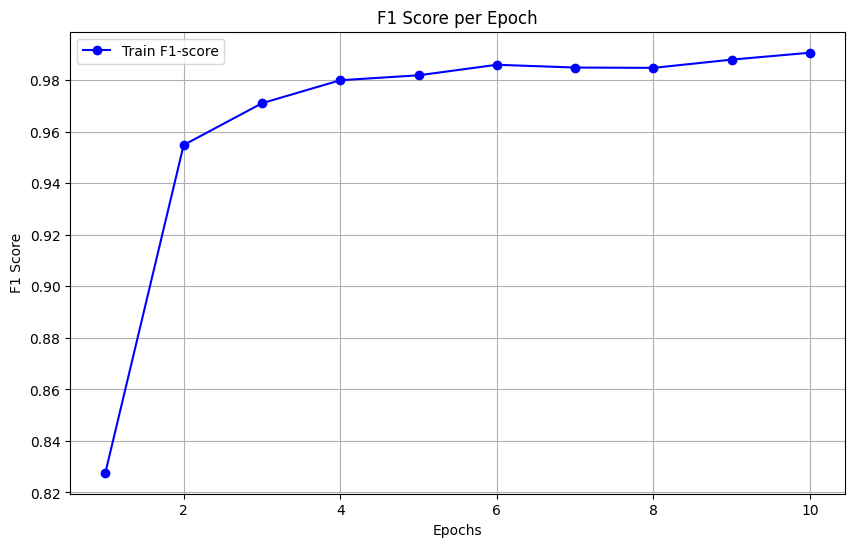

In [15]:
epochs = range(1, len(train_f1_scores) + 1)  # Создаем список номеров эпох
plt.figure(figsize=(10, 6))  # Задаем размер графика

# Строим график
plt.plot(epochs, train_f1_scores, label='Train F1-score', marker='o', color='b')


plt.xlabel('Epochs')
plt.ylabel('F1 Score')
plt.title('F1 Score per Epoch')
plt.grid(True)
plt.legend()

plt.show()

In [16]:
#Функция для предсказания на тестовых данных
def predict(model, test_loader):
    with torch.no_grad():
        logits = []

        for inputs in test_loader:
            inputs = inputs.to(DEVICE)
            model.eval()
            outputs = model(inputs).cpu()
            logits.append(outputs)

    probs = nn.functional.softmax(torch.cat(logits), dim=-1).numpy()
    return probs

In [17]:
#Стандартная обработка данных для теста
test_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

test_dataset = SimpsonsDataset(test_files, mode='test', transform=test_transforms)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [18]:
#В этом блоке выполняем предсказания для тестовых данных
with open('label_encoder.pkl', 'rb') as file:
    label_encoder = pickle.load(file)

probs = predict(model, test_loader)
predicted_labels = label_encoder.inverse_transform(np.argmax(probs, axis=1))
test_filenames = [path.name for path in test_dataset.files]

In [19]:
#Записываем предсказания в файл
import pandas as pd
my_submit = pd.read_csv("sample_submission.csv")
my_submit = pd.DataFrame({'Id': test_filenames, 'Expected': predicted_labels})
my_submit.to_csv('my_submission_9.csv', index=False)

Результат: 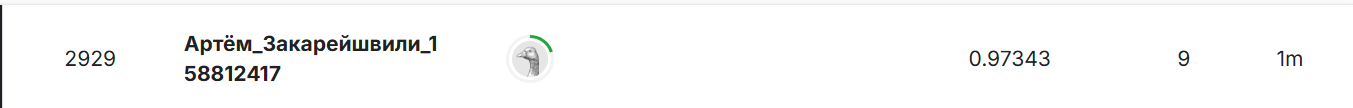